In [1]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [4]:
#Hagamos regresion logística con el data set FINAL

#Levantamos el df_final_alternativo_2
df_final_alternativo_2 = pd.read_csv('df_final_alternativo_2.csv')

#Generamos el X y el target
Xa = df_final_alternativo_2.drop(['ClasificacionNum2','ID'], axis = 1)
ya = df_final_alternativo_2['ClasificacionNum2']

#Divimos en train y en test
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa,ya, stratify=ya, test_size= 0.25)

#Estandarizamos con MinMax
scaler = MinMaxScaler()

Xa_train_std = scaler.fit_transform(Xa_train)
Xa_test_std = scaler.fit_transform(Xa_test)

In [31]:
# Buscamos los mejores hiperparametros

modelo = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Defnimos una grilla con GridSearch

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=3, random_state=999)
grid_search = GridSearchCV(estimator=modelo, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(Xa_train_std, ya_train)

# Vemos los resultados

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.764516 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.756882 (0.071119) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.758548 (0.072281) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.755824 (0.070328) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.763423 (0.067838) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.763423 (0.067838) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.764516 (0.064167) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.760556 (0.064918) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.760556 (0.064918) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.761685 (0.066353) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.737867 (0.060040) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.737867 (0.060040) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.741685 (0.057915) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.699839 (0.012004) with

In [32]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Oranges',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [33]:
#Instanciamos el modelo y los ajustamos a los datos de entrenamiento
modelo = LogisticRegression(C=10, penalty = 'l2', solver= 'liblinear')
modelo.fit(Xa_train_std, ya_train)

LogisticRegression(C=10, solver='liblinear')

In [34]:
#Para UN solo fold
#Hacemos las predicciones necesarias
ya_pred = modelo.predict(Xa_test_std)
print(ya_pred)
#Evaluamos el score
print('')
print('Score: ', accuracy_score(ya_test, ya_pred))

[1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]

Score:  0.7902439024390244


In [35]:
#Generalizamos para 20 folds
stratifiedkf=StratifiedKFold(n_splits=10)
score=cross_val_score(modelo,Xa_train_std,ya_train,cv=stratifiedkf)
print("Los scores obtenidos son {}".format(score))
print("El promedio es :{}".format(score.mean()))

Los scores obtenidos son [0.82258065 0.83870968 0.79032258 0.73770492 0.80327869 0.81967213
 0.75409836 0.70491803 0.67213115 0.70491803]
El promedio es :0.7648334214701216


In [36]:
cf_matrix_a = confusion_matrix(ya_pred,ya_test)

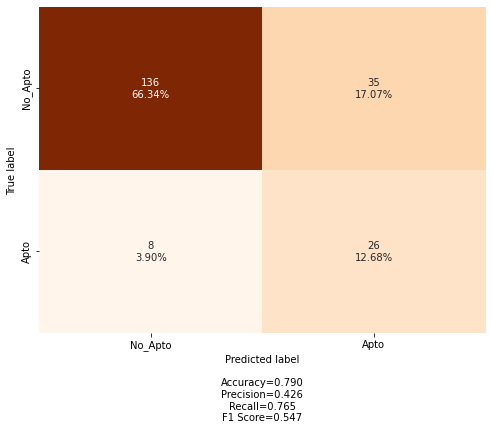

In [37]:
make_confusion_matrix(cf_matrix_a, categories= ['No_Apto', 'Apto'] , figsize=(8,6), cbar=False)

In [38]:
y_pred_proba = modelo.predict_proba(Xa_test_std)

In [39]:
display(y_pred_proba.shape, y_pred_proba)

(205, 2)

array([[0.15259833, 0.84740167],
       [0.92817441, 0.07182559],
       [0.86692105, 0.13307895],
       [0.95959393, 0.04040607],
       [0.79766573, 0.20233427],
       [0.76722839, 0.23277161],
       [0.347858  , 0.652142  ],
       [0.53534121, 0.46465879],
       [0.95998766, 0.04001234],
       [0.93913509, 0.06086491],
       [0.26156298, 0.73843702],
       [0.58284417, 0.41715583],
       [0.49745525, 0.50254475],
       [0.96092472, 0.03907528],
       [0.9745161 , 0.0254839 ],
       [0.95228399, 0.04771601],
       [0.85333025, 0.14666975],
       [0.79499285, 0.20500715],
       [0.7974671 , 0.2025329 ],
       [0.7144076 , 0.2855924 ],
       [0.98104014, 0.01895986],
       [0.8882952 , 0.1117048 ],
       [0.54868665, 0.45131335],
       [0.93141816, 0.06858184],
       [0.53534121, 0.46465879],
       [0.59001416, 0.40998584],
       [0.93581425, 0.06418575],
       [0.94156562, 0.05843438],
       [0.77077922, 0.22922078],
       [0.79707697, 0.20292303],
       [0.

In [55]:
# Nos quedamos con la columna que tiene la probabilidad positiva de cada caso
y_probs_logit_left = y_pred_proba[:,1]

#Cambiamos el umbral
ya_pred_logit = (y_probs_logit_left > 0.25).astype(int)
cf_matrix_a_logit = confusion_matrix(ya_pred_logit,ya_test)

In [56]:
print('Matrix Original')
display(confusion_matrix(ya_pred,ya_test))
print('')
print('Nueva Matrix')
display(confusion_matrix(ya_pred_logit,ya_test))

Matrix Original


array([[136,  35],
       [  8,  26]], dtype=int64)


Nueva Matrix


array([[95, 15],
       [49, 46]], dtype=int64)

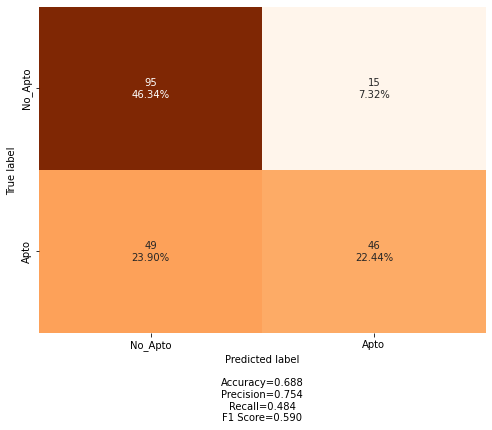

In [57]:
make_confusion_matrix(cf_matrix_a_logit, categories= ['No_Apto','Apto'] , figsize=(8,6), cbar=False)

In [46]:
from sklearn.metrics import roc_curve
fpr_log,tpr_log,thr_log = roc_curve(ya_test, y_pred_proba[:,1])

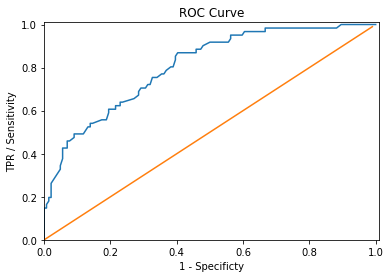

In [47]:
df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [48]:
from sklearn.metrics import auc
print('AUC=', auc(fpr_log, tpr_log))

AUC= 0.8052140255009107
